## Прогнозирование цены на жилье с помощью нейросетевой регрессионной модели

Необходимо по имеющимся данным о ценах на жильё предсказать окончательную цену каждой квартиры с учетом характеристик, с использованием нейронной сети. Описание набора данных содержит 10 наборов переменых оценки типа жилья и находится в файле `Practice_description`.


#Задание


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Считываем набор данных


Загрузим набор данных и присвоим следующими переменные:

* `train_data`: данные, используемые для обучения модели
* `test_data`: данные, используемые для тестирования модели

In [ ]:
train_data = pd.read_csv('/content/Train_1.csv')
test_data = pd.read_csv('/content/Test_1.csv')

## Подготовка данных
### Отобразим обучающие и проверочные данные:

In [ ]:
train_data.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,sale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [ ]:
test_data.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease
0,2027-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months
1,2027-08,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months
2,2027-10,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months
3,2027-03,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month
4,2028-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months


Как можно видеть, `train_data` имеет на один столбец больше, чем `test_data`, это столбец `saleprice`, для обучения модели перед применением её для предсказания меток в test_data.

### Проверяем нет ли в тестовых данных пустых значений значений (Nan)

Построим функцию `def missing_value_checker` для проверки и подсчёта пропущеных значений в test_data. А также выведем тип данных этих значений.


In [ ]:
def missing_value_checker(data):
    list = []
    for feature, content in data.items():
        if data[feature].isnull().values.any():

            sum = data[feature].isna().sum()

            type = data[feature].dtype

            print (f'{feature}: {sum}, type: {type}')

            list.append(feature)
    print(list)

    print(len(list))

missing_value_checker(test_data)

[]
0


In [ ]:
test_edited = test_data
train_edited = train_data

def nan_filler(data):
    for label, content in data.items():
        if pd.api.types.is_numeric_dtype(content): # если тип числовой
            data[label] = content.fillna(content.median()) # значения заполняются медианой столбца
        else:
            data[label] = content.astype("category").cat.as_ordered() # если не числовой
            data[label] = pd.Categorical(content).codes+1 # преобразуется в числовые коды

nan_filler(test_edited)
nan_filler(train_edited)

### Перепроверим наши данные:

In [ ]:
missing_value_checker(test_edited)

[]
0


In [ ]:
missing_value_checker(train_edited)

[]
0


In [ ]:
train_edited.shape, test_edited.shape

((210022, 11), (16, 10))

In [ ]:
test_edited.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month                16 non-null     int8   
 1   town                 16 non-null     int8   
 2   flat_type            16 non-null     int8   
 3   block                16 non-null     int64  
 4   street_name          16 non-null     int8   
 5   storey_range         16 non-null     int8   
 6   floor_area_sqm       16 non-null     float64
 7   flat_model           16 non-null     int8   
 8   lease_commence_date  16 non-null     int64  
 9   remaining_lease      16 non-null     int8   
dtypes: float64(1), int64(2), int8(7)
memory usage: 628.0 bytes


In [ ]:
train_edited.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210022 entries, 0 to 210021
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                210022 non-null  int8   
 1   town                 210022 non-null  int8   
 2   flat_type            210022 non-null  int8   
 3   block                210022 non-null  int16  
 4   street_name          210022 non-null  int16  
 5   storey_range         210022 non-null  int8   
 6   floor_area_sqm       210022 non-null  float64
 7   flat_model           210022 non-null  int8   
 8   lease_commence_date  210022 non-null  int64  
 9   remaining_lease      210022 non-null  int16  
 10  sale_price           210022 non-null  float64
dtypes: float64(2), int16(3), int64(1), int8(5)
memory usage: 7.0 MB


### Разделим данные

Поскольку мы не знаем метку (Цена) тестовых данных, для оценки модели, чтобы получить лучшую модель перед прогнозированием тестовых данных, разделим данные в файле train.scv на обучающие и проверочные данные, соотношение составляет 20%.

In [ ]:
X = train_edited.drop('sale_price', axis=1)
y = train_edited['sale_price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)

In [ ]:
X_train.shape, test_edited.shape

((168017, 10), (16, 10))

## Моделирование

### Построение и обучение модели


Создаём последовательную модель нейронной сети с помощью фрэймворка тренировки нейронных сетей: Tensorflow.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

# Установим seed для воспроизводимости
tf.random.set_seed(40)

# Создаем модель
model = Sequential([
    Dense(900, input_dim=10, activation='relu'),  # Входной слой с 10 входами и 900 нейронами
    Dense(100, activation='relu'),                # Скрытый слой со 100 нейронами
    Dense(1)    # Выходной слой с 1 нейроном
])

# Компилируем модель
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Просмотр структуры модели
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 900)            │         9,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 100)            │        90,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,101 (391.02 KB)

 Trainable params: 100,101 (391.02 KB)

 Non-trainable params: 0 (0.00 B)

"Обучим" модель на обучающих данных `X_train` и `y_train`, задав гиперпараметры модели нейронной сети: количество эпох (epochs), размер мини-выборки (batch_size) и другие.

In [ ]:
# Гиперпараметры
# epochs = 150
# batch_size = 30

# Обучение модели
history = model.fit(
    X_train,         # Обучающие признаки
    y_train,         # Метки
    epochs=130,   # Количество эпох
    batch_size=40,  # Размер мини-выборки
    validation_data=(X_val, y_val),
    verbose=1      # Уровень вывода (1 — детальный)
)

# Вывод истории обучения
print("Model training completed.")


Epoch 1/130
4201/4201 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 16664164352.0000 - mean_absolute_error: 95968.3125 - val_loss: 10748905472.0000 - val_mean_absolute_error: 73590.9062
Epoch 2/130
4201/4201 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 10654174208.0000 - mean_absolute_error: 75380.0547 - val_loss: 9622614016.0000 - val_mean_absolute_error: 69389.2656
Epoch 3/130
4201/4201 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - loss: 9771965440.0000 - mean_absolute_error: 72022.4141 - val_loss: 9268857856.0000 - val_mean_absolute_error: 68113.1406
Epoch 4/130
4201/4201 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 9487132672.0000 - mean_absolute_error: 70850.5781 - val_loss: 9072053248.0000 - val_mean_absolute_error: 67218.7578
Epoch 5/130
4201/4201 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 9295351808.0000 - mean_absolute_error: 69937.7266 - val_loss: 8929082368.0000 - val_mean_absolute_error: 66349.8594
Epoch 6/130
4201/4201 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 9145688064.0000 - mean_absolute_e

Небольшое количество нейронов дают нормальный результат, но с их увеличением до приемлемых значений результат становиться более точный.

Чем выше значение входных нейронов, чем быстрее модель выдаёт лучшее предсказание (точнее первое предсказание).

Если общее значение нейронов довольно большое , время обучения модели заметно увеличивается.


Чем больше epoch, тем точнее будут результаты, но в то же время дольше время выполнения. Но, в то же время, с совсем большим значением, может возникать переобучение модели.


При маленьких batch_size, время выполнения слишком большое. Соответственно, чем больше значение, чем больше скорость выполнения.

In [ ]:
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (168017, 10)
Shape of y_train: (168017,)


**Оценим полученные результаты**

### Прогнозирование

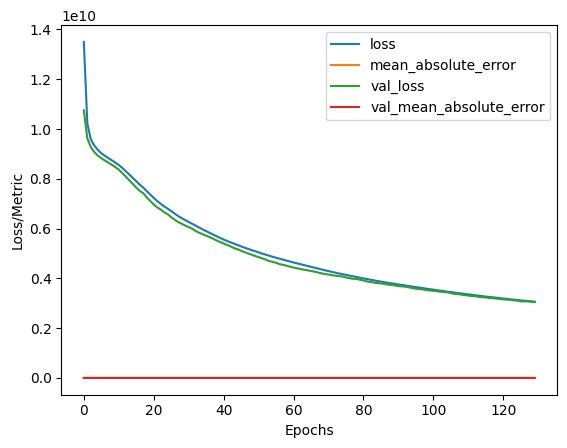

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 3095831808.0000 - mean_absolute_error: 38764.9883
Test Loss: 3045161472.0, Test MAE: 38576.2734375
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
     Actual    Predicted
0  838888.0  865820.5625
1  295000.0  367770.7500
2  595000.0  581525.4375
3  560000.0  577833.1250
4  420000.0  390900.7500
Mean Absolute Error (MAE): 38576.2769757023
Mean Squared Error (MSE): 3045163317.5739784


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Построение графика истории обучения
pd.DataFrame(history.history).plot()
plt.ylabel('Loss/Metric')  #Например, "Loss" или "Accuracy"
plt.xlabel('Epochs')
plt.show()

# Оценка на тренировочном наборе
scores = model.evaluate(X_val, y_val)
print(f"Test Loss: {scores[0]}, Test MAE: {scores[1]}")

val_preds = model.predict(X_val)

#Сравним предсказания с истинными значениями
comparison = pd.DataFrame({
    'Actual': y_val.values,
    'Predicted': val_preds.flatten()  #Преобразуем в одномерный массив
})

print(comparison.head())
mae = mean_absolute_error(y_val, val_preds)
mse = mean_squared_error(y_val, val_preds)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

In [ ]:
# Тестовая выборка
preds = model.predict(test_edited)

# Таблица с предсказаниями
output = pd.DataFrame({
    'SalePrice': np.squeeze(preds)
})

# Вывод таблицы
print(output)

# Сохранение результата
output.to_csv('submission.csv', index=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
        SalePrice
0   198670.140625
1   379554.562500
2   362373.906250
3   369120.562500
4   357591.250000
5   366246.625000
6   359847.593750
7   380009.562500
8   347056.250000
9   392438.156250
10  354032.812500
11  392514.625000
12  377768.656250
13  409652.968750
14  700668.875000
15  817453.500000
